In [17]:
#dataset is Mental Health Client-Level Data from SAMHSA
#https://www.datafiles.samhsa.gov/dataset/mental-health-client-level-data-2021-mh-cld-2021-ds0001

In [3]:
!ls

codebook_descriptions.pickle
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_mental_health_client-level_data.ipynb


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
data = pd.read_csv("mhcld_puf_2021.csv")

In [7]:
# Load data (deserialize)
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)

In [8]:
data.columns

Index(['YEAR', 'AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE',
       'CMPSERVICE', 'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2',
       'MH3', 'SUB', 'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN',
       'LIVARAG', 'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG',
       'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG',
       'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG',
       'STATEFIP', 'DIVISION', 'REGION', 'CASEID'],
      dtype='object')

In [9]:
codebook_descriptions['YEAR']

'Reporting period'

In [32]:
#drop columns
#YEAR --> numeric, all the same == 2012. DROP.
#CASEID --> numeric, unique identifier, large number. would throw off t-sne. DROP.
#SUB --> categorical, 1-13, -9 missing value. SIMPLIFY to 0/1. DROP. Redundant.
#MH1 --> categorical, 1-13, -9 missing value. DROP. Disorder columns are Boolean addition of these three.
#MH2 --> categorical, 1-13, -9 missing value. DROP. Disorder columns are Boolean addition of these three.
#MH3 --> categorical, 1-13, -9 missing value. DROP. Disorder columns are Boolean addition of these three.
#SMISED --> categorical 1-3, -9 missing value. DROP. Too vague. We can tell from the diagnoses.
#DETNLF --> categorical 1-5, -9 missing value. DROP. Don't need details of unemployment status.
#NUMMHS --> numeric, 0-3. unecessary because it's a sum of the diagnoses data. DROP.
#STATEFIP --> categorical 1-100. could one-hot, but too many columns. losing geographic information. DROP.
#REGION --> not concerned with region. DROP.
#DIVISION --> census geographical data. DROP.
drop_cols = ['YEAR','CASEID','SUB','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [33]:
data.shape

(6509025, 28)

In [12]:
#disorder columns
#they are all 0/1 data
#these are dignoses for the disorders
#there are 13 of them
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [34]:
#transform columns
#AGE, numeric, ordina. scale to 0-1.
#EDUC --> ordinal, -9 is missing value. -9 |--> 0
#GENDER --> categorical, 1-2, -9 is missing value. MAP to 0-1, -9 |--> .5
#SAP --> cateogrical, binary 1-2. -9 missing value. MAP to 0-1, -9 |--> .5
#VETERAN --> categorical 1-2, -9 missing value. MAP to 0-1, -9 |--> .5
#SPHSERVICE --> categorical, binary 1-2. MAP to 0-1.
#CMPSERVICE --> categorical, binary 1-2. MAP to 0-1.
#OPISERVICE --> categorical, binary 1-2. MAP to 0-1.
#RTCSERVICE --> categorical, binary 1-2. MAP to 0-1.
#IJSSERVICE --> categorical, binary 1-2. MAP to 0-1.
transform_cols = ['AGE','EDUC','GENDER','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [35]:
data.head()

,AGE,EDUC,ETHNIC,RACE,GENDER,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,IJSSERVICE,...,CONDUCTFLG,DELIRDEMFLG,BIPOLARFLG,DEPRESSFLG,ODDFLG,PDDFLG,PERSONFLG,SCHIZOFLG,ALCSUBFLG,OTHERDISFLG
0,0.785714,0.8,2,3,0.0,1,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
1,0.500000,0.0,3,3,1.0,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2,0.357143,1.0,4,5,1.0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1.000000,0.0,3,3,1.0,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,0.285714,0.8,4,5,1.0,0,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0


In [36]:
#find the categorical columns w/ more than two categorices
#encode them with one-hot encoding
#ETHNIC --> categorical, 1-4, -9 is missing value. ONE-HOT.
#RACE --> categorical, 1-6, -9 is missing value. ONE-HOT.
#MARSTAT --> categorical, 1-4, -9 missing value. ONE-HOT.
#EMPLOY --> categorical, 1-5, -9 missing value. ONE-HOT.
#LIVARAG --> categorical 1-3, -9 missing value. ONE-HOT
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

27


In [39]:
data.head()

,AGE,EDUC,GENDER,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,IJSSERVICE,SAP,VETERAN,...,EMPLOY_-9,EMPLOY_1,EMPLOY_2,EMPLOY_3,EMPLOY_4,EMPLOY_5,LIVARAG_-9,LIVARAG_1,LIVARAG_2,LIVARAG_3
0,0.785714,0.8,0.0,1,0,1,1,1,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.500000,0.0,1.0,1,0,0,1,1,0.0,0.5,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.357143,1.0,1.0,0,1,1,1,1,1.0,0.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.000000,0.0,1.0,1,0,1,1,1,0.5,0.5,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.285714,0.8,1.0,0,1,1,1,1,1.0,0.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
#perform PCA without CAS connection
from sklearn import datasets, decomposition
#fill missing values
#X = data.fillna(data.mean())
#drop missing values
NUM_POINTS = 10_000
X = data.dropna()
X = X[:NUM_POINTS]
n_samples = X.shape[0]

In [41]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X.shape

(10000, 50)

In [42]:
#https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
# We center the data and compute the sample covariance matrix
X_centered = X - np.mean(X, axis=0)
cov_matrix = np.dot(X_centered.T, X_centered) / n_samples
eigenvalues = pca.explained_variance_
for eigenvalue, eigenvector in zip(eigenvalues, pca.components_):    
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
    print(eigenvalue)

0.6823012426693007
0.6823694796169905
0.4921820000375944
0.4922312231031153
0.42285943422461464
0.42290172418960364


In [43]:
#create pandas dataframes from label and pca transformed data
X_transform = pca.transform(X)
transform_df = pd.DataFrame(X_transform,columns=['score0','score1','score2'])

In [44]:
X_transform.shape

(10000, 3)

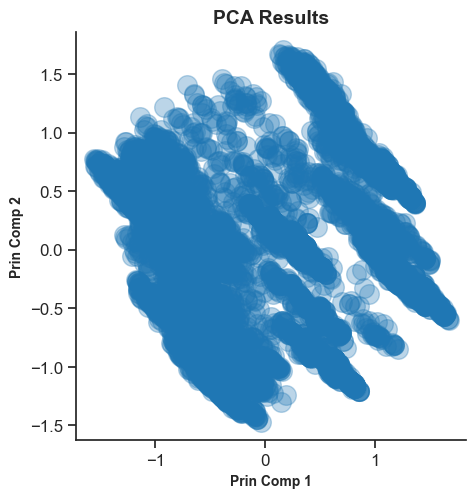

In [45]:
# Plot of PCA

# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot(x='score0',
           y='score1',
           data=transform_df,
           fit_reg=False,
           legend=True,
           #size=9,
           #hue='score2',
           scatter_kws={"s":200, "alpha":0.3})

plt.title('PCA Results', weight='bold').set_fontsize('14')
plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')
plt.savefig('plots/pca_mental-health_client-level.png')

In [46]:
from sklearn.manifold import TSNE

In [47]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)

In [158]:
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.061s...
[t-SNE] Computed neighbors for 100000 samples in 31.907s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

In [159]:
tsne_df = pd.DataFrame(columns=['tsne-2d-one','tsne-2d-two'])
tsne_df['tsne-2d-one'] = tsne_results[:,0]
tsne_df['tsne-2d-two'] = tsne_results[:,1]

In [160]:
tsne_df.shape

(100000, 2)

In [161]:
#NOTE: 
#t-SNE depends heavily on perplexity
#ensure no id column got mixed in
tsne_df.head(10)

,tsne-2d-one,tsne-2d-two
0,-19.247538,8.897477
1,0.647789,-82.690475
2,-1.807802,-0.604596
3,82.576591,142.317169
4,0.597883,15.735122
5,13.859464,-5.496855
6,8.597726,8.283395
7,19.156935,-5.267632
8,-3.299580,17.438335
9,21.824375,14.447910


In [166]:
#could just map 0/1 string to binary number
#too many categories. 2^7=128. need to reduce
#so create a label for those which are purely 1 for some disorder, and 0 for all others
#use separate category for uncategorized data
#use this as a hue to color the graph
labels = []
for row in data[:NUM_POINTS].iterrows():
  #binary number encoding of disorders
  #labels.append(sum(row[1][i]*2**i for i in range(len(data.columns))))
  #sum the total number of disorders
  #labels.append(sum(row[1][i] for i in range(len(data.columns))))
  #unique labels for pure disorders, separate categories for multiple or no disorders
  if sum(row[1]) == 0:
    #labels.append(0)
    labels.append('no_disorder')
  if sum(row[1]) == 1:
    #get the index (string) of the column with value 1
    labels.append(row[1][row[1] == 1].index[0])
  if sum(row[1]) > 1:
    #labels.append(len(data.columns)+1)
    labels.append('multi-disorder')

label_df = pd.DataFrame(labels,columns=['label'])

In [167]:
tsne_results_labeled = label_df.merge(tsne_df, left_index=True, right_index=True)

/var/folders/4d/rp7dhwss6znf18sks0v304d80000gn/T/ipykernel_5248/3351864616.py:3: UserWarning: 
The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.
  plot = sns.scatterplot(


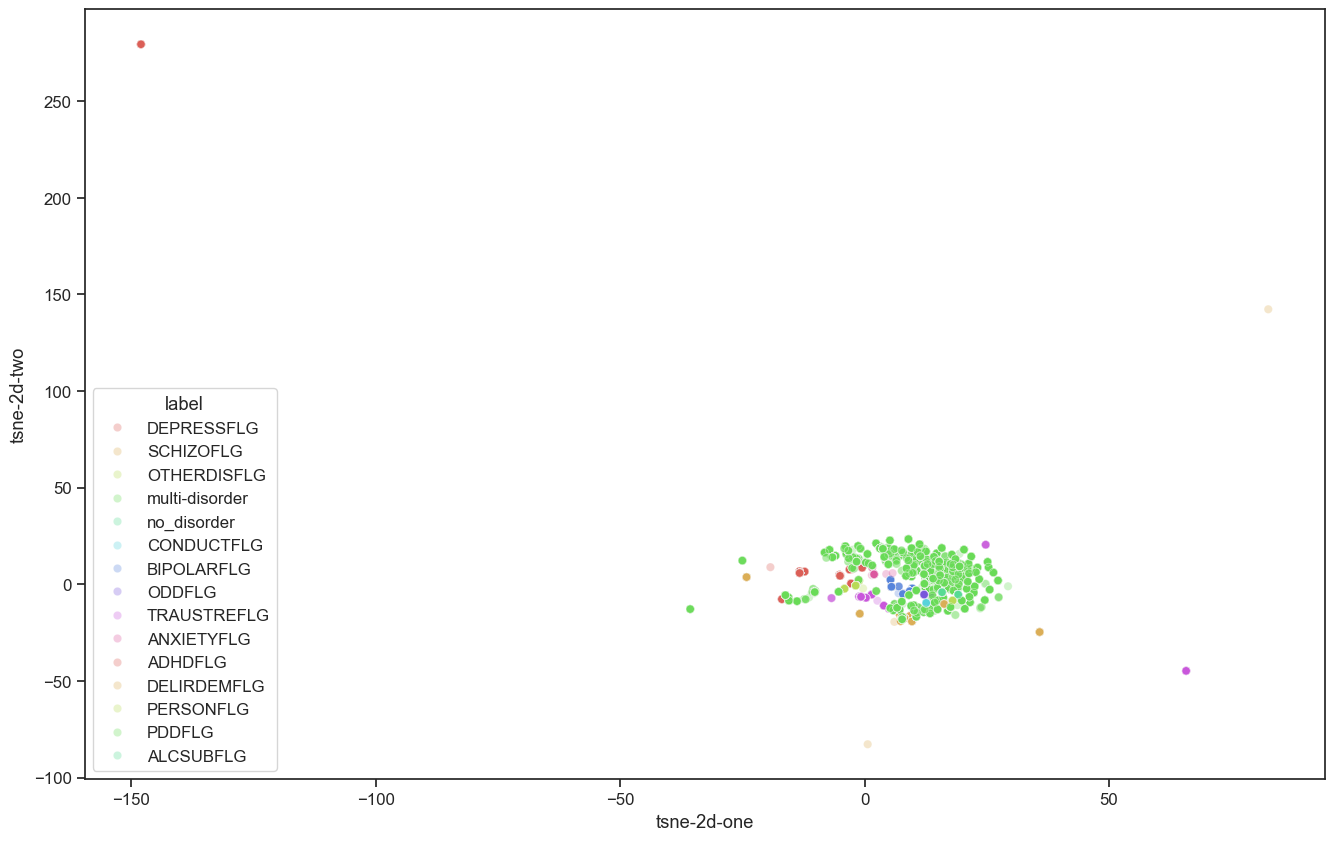

In [168]:
#plot the t-SNE results
plt.figure(figsize=(16,10))
plot = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=tsne_results_labeled,
    legend="full",
    alpha=0.3
)

In [169]:
fig = plot.get_figure()
fig.savefig("./plots/tsne_plot_mental-health_client-level_data_perplexity=50_num-data-points=100_000_num-iters=300.png")